<a href="https://colab.research.google.com/github/YossefM1/LearningPytorch/blob/main/WorkFlow/CircleIdentificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we write an algorithm that estimates the following parametric function:
            $$f(\theta) = (r \cdot \cos(\theta), \ r \cdot \sin(\theta)) + N$$
Where:  
$\theta$ is the input angle (between $0$ and $2\pi$)  
$r$ is the constant radius (in our case $2.5$)  
$N$ is Noise

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
print(torch.__version__ )
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.9.0+cu126
Using device: cuda


In [ ]:
# Create the DATA
r = 2.5
pi = torch.pi
step = 2*pi / 1000 # 100 points from 0 to 2pi

angle = torch.arange(0, 2*pi, step)
x = r * torch.cos(angle) + r/100 * torch.randn(angle.size())
y = r * torch.sin(angle) + r/100 * torch.randn(angle.size())
data = torch.stack((x, y), dim=1).to(device)
print(f"Data shape: {data.shape}, Data device: {data.device}")


Data shape: torch.Size([1000, 2]), Data device: cuda:0


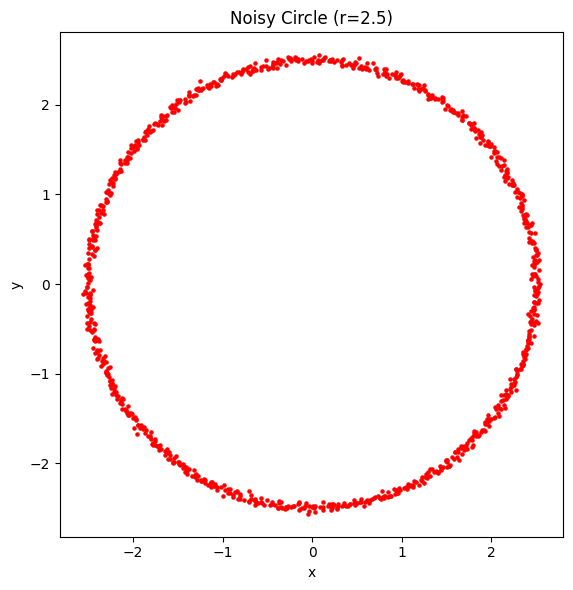

In [ ]:
#%matplotlib widget     % This line doesn't work on Colab

fig = plt.figure(figsize=(6, 6)) # Set figure size to be square
ax = fig.add_subplot(111) # Standard 2D plot

# 1. Convert tensors to numpy (move to CPU first if on GPU)
# 2. Plot x vs y
ax.scatter(x.cpu().numpy(), y.cpu().numpy(), s=5, c='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Noisy Circle (r={r})')

# Important: Force the aspect ratio to be equal so the circle
#  doesn't look like an oval
ax.set_aspect('equal', 'box')

fig.tight_layout()
plt.show()
#plt.close()


In [ ]:
# Split data into training and test sets
# --- 1. Define Split Sizes ---
n_samples = data.shape[0]          # 100
n_train = int(0.8 * n_samples)     # 80
n_test = n_samples - n_train       # 20

# --- 2. Generate Shuffled Indices ---
# This creates a random order (e.g., [4, 92, 12, ...]) so points are mixed
indices = torch.randperm(n_samples)

train_indices = indices[:n_train]
test_indices = indices[n_train:]

# --- 3. Split the Data ---
# Inputs (Angle)
angle_train = angle[train_indices]
angle_test  = angle[test_indices]

# Targets (x, y points)
data_train = data[train_indices]
data_test  = data[test_indices]

print(f"Train shapes: Angle {angle_train.shape}, Data {data_train.shape}")
print(f"Test shapes:  Angle {angle_test.shape},  Data {data_test.shape}")


Train shapes: Angle torch.Size([800]), Data torch.Size([800, 2])
Test shapes:  Angle torch.Size([200]),  Data torch.Size([200, 2])


In [ ]:
def plot_predictions_2d(train_data, test_data, predictions=None):
    """
    Plots training data, test data, and optional predictions in 2D.
    Expects inputs of shape (N, 2) where col 0 is x and col 1 is y.
    """
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)

    # Helper: Convert PyTorch tensors to Numpy arrays (handling GPU/gradients)
    def to_numpy(tensor):
        return tensor.cpu().detach().numpy() if hasattr(tensor, 'cpu') else tensor

    # --- 1. Training Data (Blue/Cyan) ---
    # data[:, 0] is x, data[:, 1] is y
    tr_x = to_numpy(train_data[:, 0])
    tr_y = to_numpy(train_data[:, 1])
    ax.scatter(tr_x, tr_y, c='b', s=10, label='Training data')

    # --- 2. Test Data (Green) ---
    ts_x = to_numpy(test_data[:, 0])
    ts_y = to_numpy(test_data[:, 1])
    ax.scatter(ts_x, ts_y, c='g', s=20, label='Testing data')

    # --- 3. Predictions (Red) ---
    if predictions is not None:
        pred_x = to_numpy(predictions[:, 0])
        pred_y = to_numpy(predictions[:, 1])
        # Using a distinct marker 'x' to see them clearly over the dots
        ax.scatter(pred_x, pred_y, c='r', s=20, label='Predictions', marker='x')

    # Formatting
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Circle Function Estimation')

    # Critical for circles: ensures the plot is square
    ax.set_aspect('equal', 'box')

    ax.legend()
    plt.show()

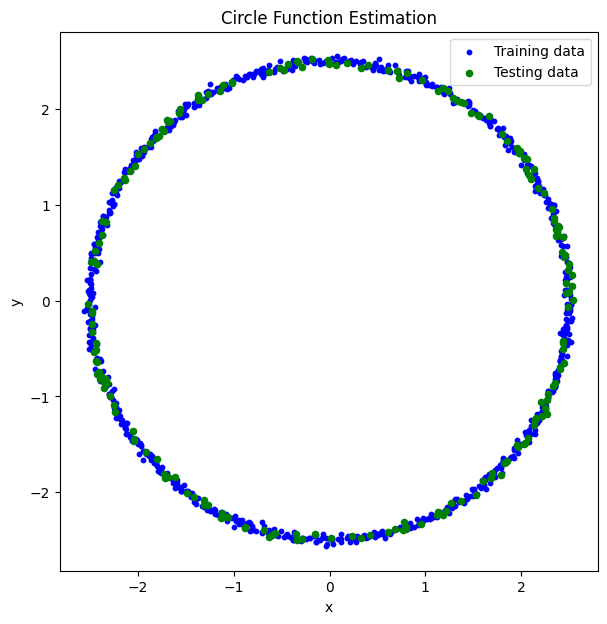

In [ ]:
plot_predictions_2d(data_train, data_test)

## Build a PyTorch linear model

In [ ]:
# Create the model by subclassing nn.Module
class CircleModelYM(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- FIXED HERE ---
            # in_features from is 2 because we use [sin(theta), cos(theta)]
            # as an input
            nn.Linear(in_features=2, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # We no longer need the unsqueeze check since x is already [N, 2]
        return self.layer_stack(x)

# Set random seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model and send it to the target device
model_1 = CircleModelYM().to(data.device) # Using data.device to match your data

# Print out the model's structure
print(model_1)

CircleModelYM(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

Training
For training we need:  

* Loss function  
* Optimizer  
* Trainig loop  
* Testing loop  

In [ ]:
# Setup loss function
# L1Loss (Mean Absolute Error) is robust and works well for regression
#loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()

# Setup optimizer
# We use SGD (Stochastic Gradient Descent) as requested.
# params: The model parameters we want to update (weights and biases)
# lr: The learning rate (step size). If the model doesn't learn, try 0.1 or 0.001
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

print(f"Loss Function: {loss_fn}")
print(f"Optimizer: {optimizer}")

Loss Function: MSELoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [ ]:
# Training loop
torch.manual_seed(42)

epochs = 10000

# Put data on target device (device agnostic code)
angle_train = angle_train.to(device)
data_train  = data_train.to(device)
angle_test  = angle_test.to(device)
data_test   = data_test.to(device)

# Transform input: [N, 1] -> [N, 2]
# We feed sin(theta) and cos(theta) instead of just theta
train_inputs = torch.stack([torch.sin(angle_train), torch.cos(angle_train)], dim=1)
test_inputs  = torch.stack([torch.sin(angle_test),  torch.cos(angle_test)],  dim=1)

# Loop through data
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    # Input is just the Angle (theta), Output is predicted (x, y)
    #y_pred = model_1(angle_train)
    y_pred = model_1(train_inputs)

    # 2. Calculate loss
    # Compare Predicted (x,y) vs Actual (x,y)
    loss = loss_fn(y_pred, data_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass on test data
        #test_pred = model_1(angle_test)
        test_pred = model_1(test_inputs)

        # 2. Calculate test loss
        test_loss = loss_fn(test_pred, data_test)

    # Print out what's happening
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 2.87083 | Test Loss: 2.83237
Epoch: 200 | Train Loss: 0.99228 | Test Loss: 0.98390
Epoch: 400 | Train Loss: 0.19423 | Test Loss: 0.19427
Epoch: 600 | Train Loss: 0.02648 | Test Loss: 0.02721
Epoch: 800 | Train Loss: 0.00482 | Test Loss: 0.00529
Epoch: 1000 | Train Loss: 0.00250 | Test Loss: 0.00285
Epoch: 1200 | Train Loss: 0.00223 | Test Loss: 0.00254
Epoch: 1400 | Train Loss: 0.00216 | Test Loss: 0.00246
Epoch: 1600 | Train Loss: 0.00212 | Test Loss: 0.00241
Epoch: 1800 | Train Loss: 0.00208 | Test Loss: 0.00236
Epoch: 2000 | Train Loss: 0.00204 | Test Loss: 0.00231
Epoch: 2200 | Train Loss: 0.00200 | Test Loss: 0.00227
Epoch: 2400 | Train Loss: 0.00197 | Test Loss: 0.00223
Epoch: 2600 | Train Loss: 0.00193 | Test Loss: 0.00219
Epoch: 2800 | Train Loss: 0.00190 | Test Loss: 0.00215
Epoch: 3000 | Train Loss: 0.00186 | Test Loss: 0.00212
Epoch: 3200 | Train Loss: 0.00183 | Test Loss: 0.00208
Epoch: 3400 | Train Loss: 0.00180 | Test Loss: 0.00205
Epoch: 3600 | Tra

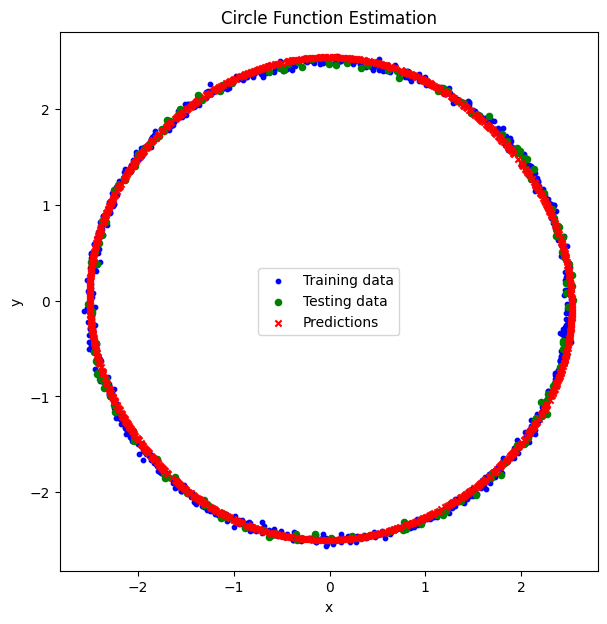

In [ ]:
plot_predictions_2d(data_train, data_test,y_pred)


### הסבר על הקלט של המודל

אציין כי בתחילה המודל קיבל כקלט את הזווית בלבד (כלומר ערך בין $0$ ל-$2\pi$).  
הבעיה בגישה זו הייתה שהמודל התקשה "להבין" שהנקודות $0$ ו-$2\pi$ הן למעשה אותה   נקודה גיאומטרית.  
כתוצאה מכך, לא נוצר חיבור רציף בין הנקודות והתקבל "נתק".

במודל הסופי המיושם, הכנסנו את הקלטים באמצעות פונקציות הסינוס והקוסינוס של הזווית. בצורה זו, הערכים של $0$ ו-$2\pi$ זהים מתמטית, ולכן נקודת התפר ביניהן מתחברת היטב ונוצר מעגל מושלם.

| מאפיין | גרסה 1 (זווית בלבד) | גרסה 2 (סינוס/קוסינוס) |
| :--- | :--- | :--- |
| **הקלט** | מספר אחד (קו ישר מ-$0$ עד $6.28$) | שני מספרים (קואורדינטות מעגליות) |
| **האתגר** | המודל צריך להבין לבד ש-$0$ ו-$6.28$ זה אותה נקודה | המעגליות כבר "מובנית" בקלט |
| **ויזואלית** | נוצר "זנב" או נתק בנקודת החיבור | מעגל סגור ורציף לחלוטין |
| **דימוי** | לנסות לכופף מקל ישר לחישוק | לקחת חישוק קיים ולשנות לו את הגודל |